## Performance test on Gaussian blobs

In this notebook we compare the clustering performance of k-means++, HDBSCAN, Quickshift++, and CLASSIX. The dataset is synthetically generated, corresponding to 5 Gaussian blobs in 5-dimensional space. There are 20,000 data points in total.

The hyperparameters of each method have been tuned by careful grid search. Should you find a set of parameters that improves a method significantly, please let us know and we will update this notebook.

The runtimes and plots of the computed clusterings are shown at the bottom of this notebook.

In [9]:
import hdbscan
from sklearn.cluster import KMeans
from quickshift.QuickshiftPP import *
from threadpoolctl import threadpool_limits
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from classix import CLASSIX, loadData
import classix
from time import time
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
import collections

import pkg_resources
print("Kmeans++ version:", pkg_resources.get_distribution('scikit-learn').version)
print("HDBSCAN  version:", pkg_resources.get_distribution('hdbscan').version)
print("Quickshift++ ver: Aug 2018") # https://github.com/google/quickshift
print("CLASSIX  version:", classix.__version__)

Kmeans++ version: 1.2.1
HDBSCAN  version: 0.8.33
Quickshift++ ver: Aug 2018
CLASSIX  version: 1.0.5


In [10]:
fdim=5
size=int(2e5)
clusterNum = 5

lari = list()
lami = list()
runtime = list()
X, y = make_blobs(n_samples=size, centers=clusterNum, n_features=fdim,
                  random_state=42)
min_cluster = min(collections.Counter(y).items(), key=lambda x: x[1])[1]

with threadpool_limits(limits=1, user_api='blas'):
    clx = CLASSIX(radius=0.17, verbose=0)
    st = time()
    clx.fit(X)
    et = time()
    print("CLASSIX uses time:", et - st)
    print("ARI:", ari(clx.labels_, y))
    print("AMI:", ami(clx.labels_, y))
    lari.append(ari(clx.labels_, y))
    lami.append(ami(clx.labels_, y))
    runtime.append(et - st)

    _hdbscan = hdbscan.HDBSCAN(min_cluster_size=5000, algorithm='best')
    st = time()
    _hdbscan.fit(X)
    et = time()
    print("HDBSCAN uses time:", et - st)
    print("ARI:", ari(_hdbscan.labels_, y))
    print("AMI:", ami(_hdbscan.labels_, y))
    lari.append(ari(_hdbscan.labels_, y))
    lami.append(ami(_hdbscan.labels_, y))
    runtime.append(et - st)

    quicks = QuickshiftPP(k=80, beta=0.9)
    st = time()
    quicks.fit(X.copy(order='C'))
    et = time()
    print("Quickshift uses time:", et - st)
    print("ARI:", ari(quicks.memberships, y))
    print("AMI:", ami(quicks.memberships, y))
    lari.append(ari(quicks.memberships, y))
    lami.append(ami(quicks.memberships, y))
    runtime.append(et - st)

    kmeans = KMeans(n_clusters=clusterNum, init='k-means++', n_init='auto', random_state=1)
    st = time()
    kmeans.fit(X)
    et = time()
    print("kmeans uses time:", et - st)
    print("ARI:", ari(kmeans.labels_, y))
    print("AMI:", ami(kmeans.labels_, y))
    lari.append(ari(kmeans.labels_, y))
    lami.append(ami(kmeans.labels_, y))
    runtime.append(et - st)

lari = np.asarray(lari)
lami = np.asarray(lami)
runtime = np.asarray(runtime)

labels_ = [clx.labels_, _hdbscan.labels_, quicks.memberships, kmeans.labels_]# , depddp_class]
np.save("result/exp1/blobs_ari.npy", lari)
np.save("result/exp1/blobs_ami.npy", lami)
np.save("result/exp1/blobs_runtime.npy", runtime)
np.save("result/exp1/blobs_labels.npy", labels_)

CLASSIX uses time: 0.702845573425293
ARI: 1.0
AMI: 1.0
HDBSCAN uses time: 189.43794989585876
ARI: 0.9967470647150922
AMI: 0.9936118389400329
Quickshift uses time: 46.86378359794617
ARI: 1.0
AMI: 1.0
kmeans uses time: 0.45088672637939453
ARI: 1.0
AMI: 1.0


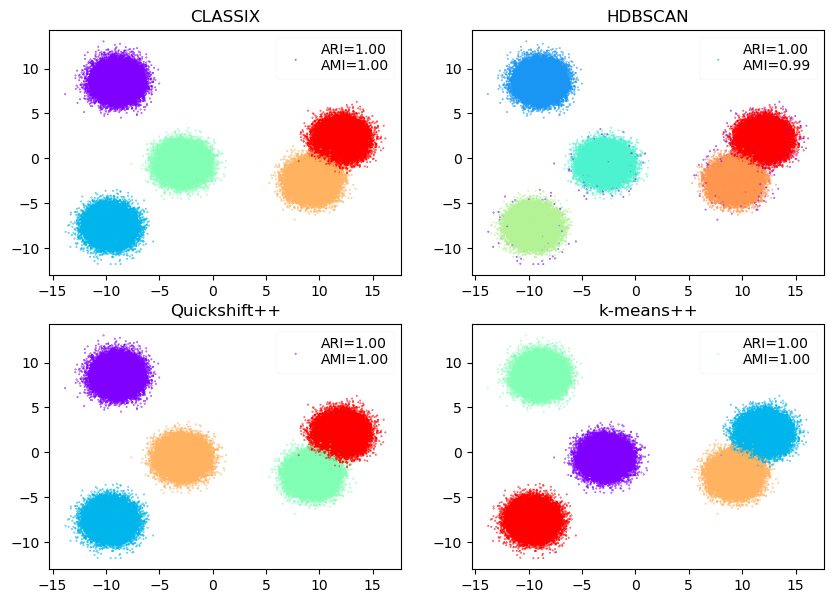

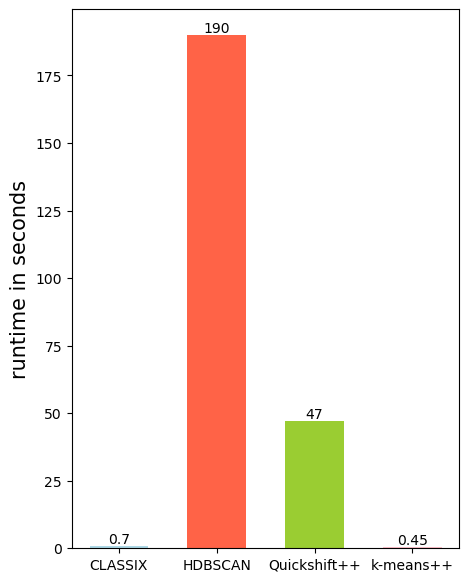

In [13]:
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def sigificant_digit(number, digits=4):
    return round(number, digits - int(math.floor(math.log10(abs(number)))) - 1)
algorithms = ['CLASSIX', 'HDBSCAN', 'Quickshift++', 'k-means++']

lari = np.load("result/exp1/blobs_ari.npy")
lami = np.load("result/exp1/blobs_ami.npy")
labels = np.load("result/exp1/blobs_labels.npy")
runtime = np.load("result/exp1/blobs_runtime.npy")
runtime = [sigificant_digit(c, 2) for c in runtime]

pca = PCA(n_components=2)
X = pca.fit_transform(X)

fig, axs = plt.subplots(2, 2, figsize=(10,7))
# fig.suptitle('Gassian blobs')

axs[0, 0].scatter(X[:, 0], X[:, 1], s=0.1, c=labels[0], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[0], lami[0]))
axs[0, 0].set_title(algorithms[0])
axs[0, 0].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[0, 1].scatter(X[:, 0], X[:, 1], s=0.1, c=labels[1], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[1], lami[1]))
axs[0, 1].set_title(algorithms[1])
axs[0, 1].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[1, 0].scatter(X[:, 0], X[:, 1], s=0.1, c=labels[2], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[2], lami[2]))
axs[1, 0].set_title(algorithms[2])
axs[1, 0].legend(loc='upper right', fancybox=True, framealpha=0.1)
axs[1, 1].scatter(X[:, 0], X[:, 1], s=0.1, c=labels[3], cmap='rainbow', label='ARI={0:.2f}\nAMI={1:.2f}'.format(lari[3], lami[3]))
axs[1, 1].set_title(algorithms[3])
axs[1, 1].legend(loc='upper right', fancybox=True, framealpha=0.1)
plt.savefig('result/exp1/scatter_blobs.png', bbox_inches='tight')
plt.show()

color = ['lightblue', 'tomato', 'yellowgreen', 'pink']
plt.figure(figsize=(5, 7))
plt.bar(algorithms, runtime, width=0.6, color=color)
#plt.yscale('log')
plt.ylabel('runtime in seconds', fontsize=15)
# add Bar labels
for c in plt.gca().containers:
    plt.gca().bar_label(c)
    
plt.savefig('result/exp1/bar_blobs.png', bbox_inches='tight')
plt.show()